In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [9]:
import fastparquet
def read_data():
    df=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2.parq").to_pandas()
    print df.shape
    return df.drop(['target','fold'],axis=1)
%time df=read_data()

(6582476, 52)
CPU times: user 4.25 s, sys: 2.35 s, total: 6.6 s
Wall time: 6.6 s


In [15]:
for v in df:
    print v, len(set(df[v].values))

 market 25
f_0 14
f_1 3
f_2 4
f_3 820981
f_4 2752462
f_5 22
f_6 61738
f_7 683
f_8 20646
f_9 3
f_10 123441
f_11 1778631
f_12 2842469
f_13 888392
f_14 805835
f_15 2877298
f_16 6
f_17 129202
f_18 2667337
f_20 6
f_21 183918
f_22 2395864
f_23 17
f_24 5
f_25 1628990
f_26 75179
f_27 49826
f_28 3792
f_29 4
f_30 2870932
f_31 5
f_32 340317
f_33 33
f_34 14520
f_35 42608
f_36 2111694
f_37 118599
f_38 312461
f_39 173054
f_40 1242277
f_41 1864079
latest_target 21
latest3_mean 57
latest2_mean 40
mkt_mean 524
latest_target_nil 2
latest3_mean_nil 2
latest2_mean_nil 2
mkt_mean_nil 2


In [96]:
from scipy.special import erfinv
def rank_gaussian(x):
    s=sorted(set(x))
    n=len(s)
    p=(2*np.array(range(1,n+1))/float(n+1)-1)*0.999
    print x.name,n, np.min(p),np.max(p)
    p=erfinv(p)
    m={u:v for u,v in zip(s,p)}
    x=x.map(lambda u: m[u])
    return x-x.mean()

In [97]:
lst=[]
for col in df.columns:
    x=df[col]
    newx=rank_gaussian(x).values.astype(np.float32)
    lst.append(newx)

market 25 -0.922153846154 0.922153846154
f_0 14 -0.8658 0.8658
f_1 3 -0.4995 0.4995
f_2 4 -0.5994 0.5994
f_3 820981 -0.998997566329 0.998997566329
f_4 2752462 -0.998999274105 0.998999274105
f_5 22 -0.912130434783 0.912130434783
f_6 61738 -0.99896763796 0.99896763796
f_7 683 -0.996078947368 0.996078947368
f_8 20646 -0.998903230494 0.998903230494
f_9 3 -0.4995 0.4995
f_10 123441 -0.998983814261 0.998983814261
f_11 1778631 -0.998998876665 0.998998876665
f_12 2842469 -0.99899929709 0.99899929709
f_13 888392 -0.998997750995 0.998997750995
f_14 805835 -0.998997520587 0.998997520587
f_15 2877298 -0.998999305599 0.998999305599
f_16 6 -0.713571428571 0.713571428571
f_17 129202 -0.998984535963 0.998984535963
f_18 2667337 -0.998999250939 0.998999250939
f_20 6 -0.713571428571 0.713571428571
f_21 183918 -0.998989136522 0.998989136522
f_22 2395864 -0.998999166063 0.998999166063
f_23 17 -0.888 0.888
f_24 5 -0.666 0.666
f_25 1628990 -0.998998773474 0.998998773474
f_26 75179 -0.998973423783 0.998973423

In [101]:
newdf=pd.DataFrame(np.array(lst).T,columns=['rg_'+u for u in df.columns],index=df.index)

In [103]:
newdf.tail()

rg_market    rg_f_0    rg_f_1    rg_f_2    rg_f_3    rg_f_4  \
id                                                                      
15203950  -0.387262 -0.348419  0.378236  0.058975  0.981253  0.755273   
15203951   0.322468 -0.110367  0.378236 -0.714344 -0.626551 -0.751604   
15203952   0.322468 -0.110367  0.378236 -0.714344 -0.808406 -0.955343   
15203953   0.813589  0.494904  0.378236  0.474373  1.398547  1.570900   
15203954  -0.552426  0.769737 -0.098144  0.058975 -0.566532 -0.500473   

            rg_f_5    rg_f_6    rg_f_7    rg_f_8       ...          rg_f_40  \
id                                                     ...                    
15203950 -0.014614 -0.097357 -0.269295  0.485734       ...        -1.210730   
15203951 -0.669869 -0.097357 -0.947013 -0.222507       ...        -0.019551   
15203952 -0.669869 -0.097357 -0.947013 -0.328080       ...        -0.312326   
15203953  0.498469 -0.097357  0.479370  0.439649       ...         1.699597   
15203954 -0.256815 -0.097357 -0.055516 -0.328080       ...        -0.408059   

           rg_f_41  rg_latest_target  rg_latest3_mean  rg_latest2_mean  \
id                                                                       
15203950 -0.086448          0.007937         0.005797         0.009837   
15203951 -0.126015          0.007937         0.005797         0.009837   
15203952 -0.430338          0.007937         0.005797         0.009837   
15203953  1.654479          0.007937         0.005797         0.009837   
15203954 -0.482392          0.007937         0.005797         0.009837   

          rg_mkt_mean  rg_latest_target_nil  rg_latest3_mean_nil  \
id                                                                 
15203950     0.038103               0.36807             0.133769   
15203951     0.038103               0.36807             0.133769   
15203952     0.038103               0.36807             0.133769   
15203953     0.038103               0.36807             0.133769   
15203954     0.038103               0.36807             0.133769   

          rg_latest2_mean_nil  rg_mkt_mean_nil  
id                                              
15203950             0.230433         0.371281  
15203951             0.230433         0.371281  
15203952             0.230433         0.371281  
15203953             0.230433         0.371281  
15203954             0.230433         0.371281  

[5 rows x 50 columns]

market


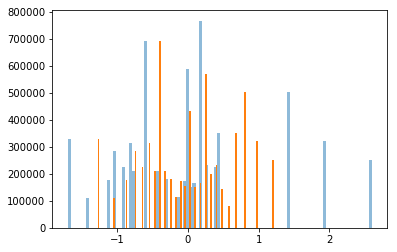

f_0


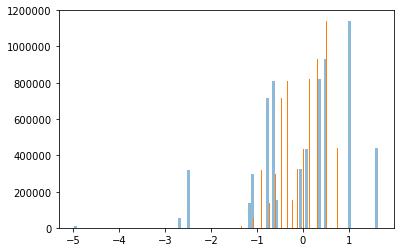

f_1


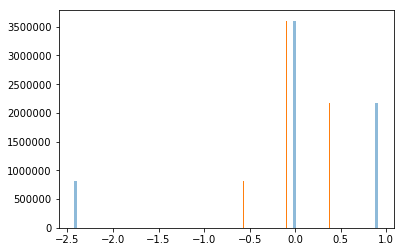

f_2


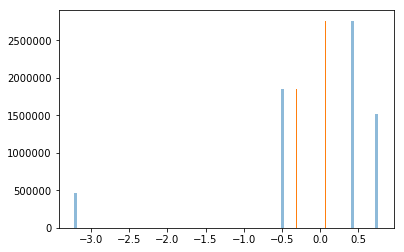

f_3


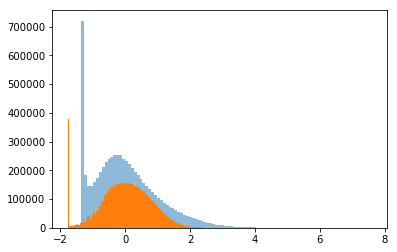

f_4


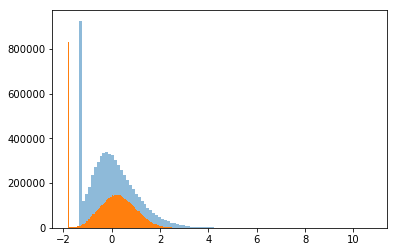

f_5


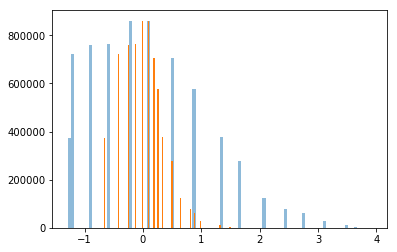

f_6


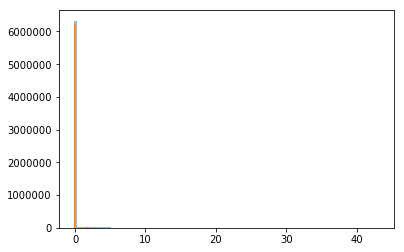

f_7


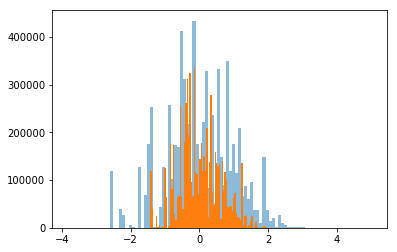

f_8


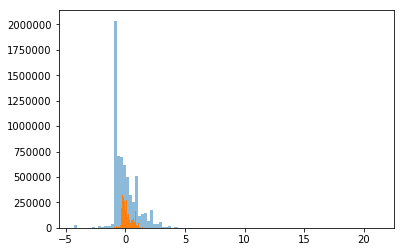

f_9


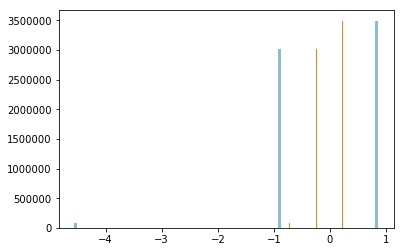

f_10


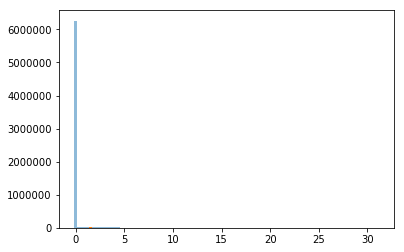

f_11


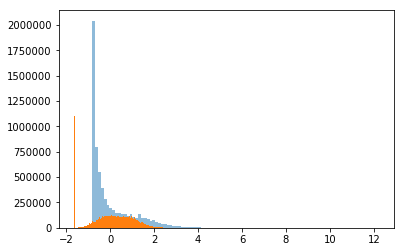

f_12


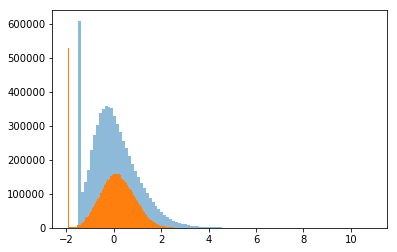

f_13


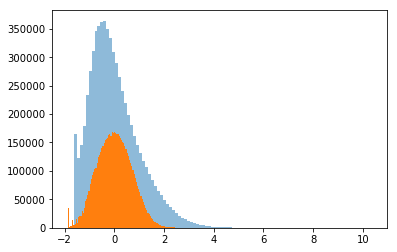

f_14


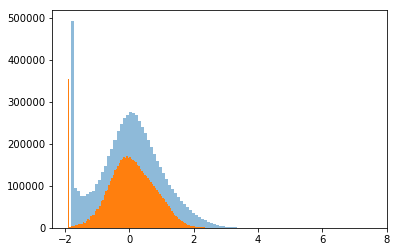

f_15


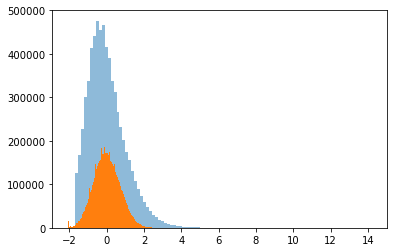

f_16


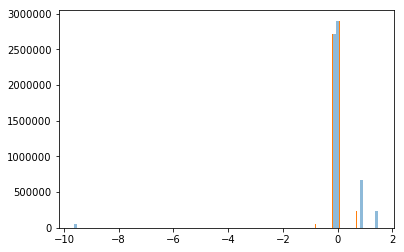

f_17


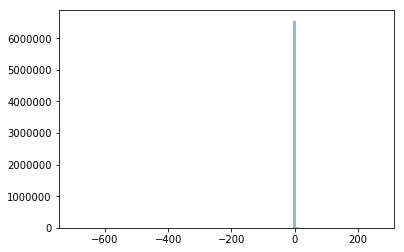

f_18


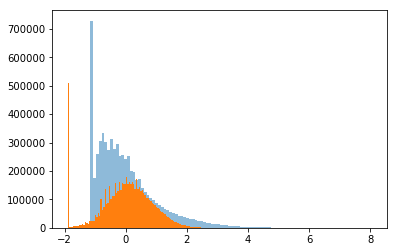

f_20


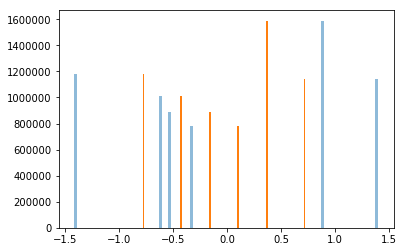

f_21


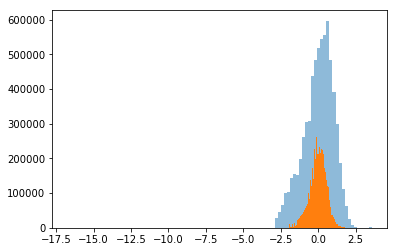

f_22


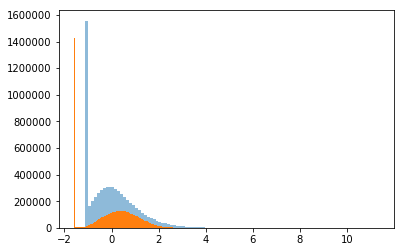

f_23


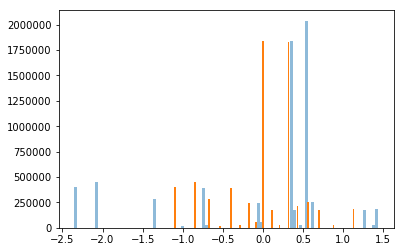

f_24


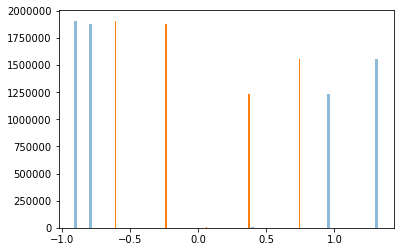

f_25


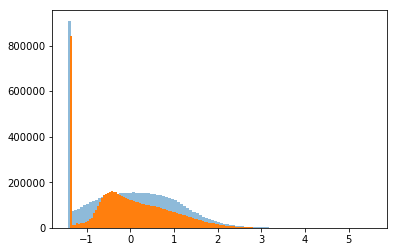

f_26


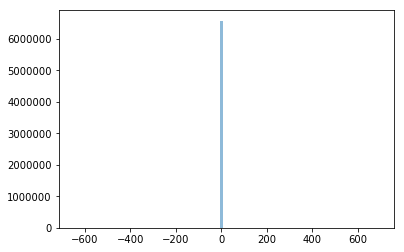

f_27


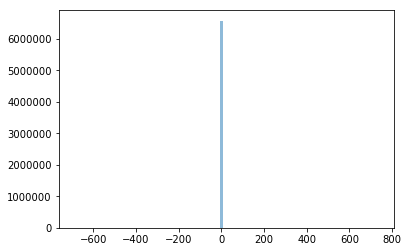

f_28


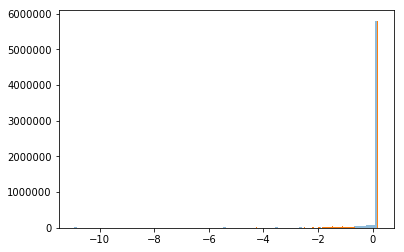

f_29


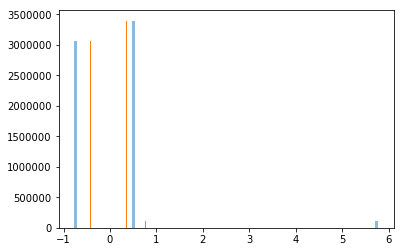

f_30


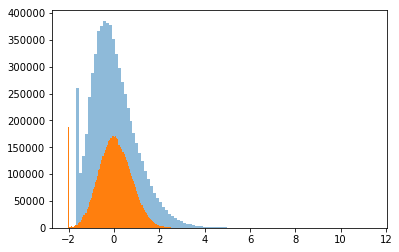

f_31


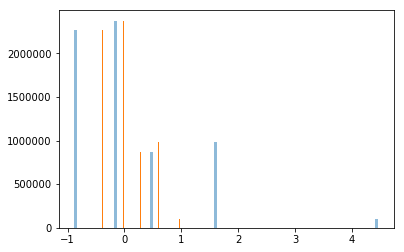

f_32


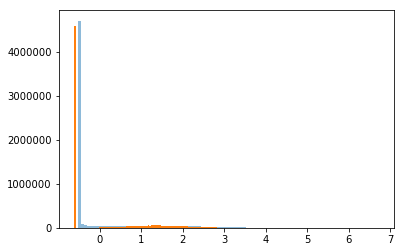

f_33


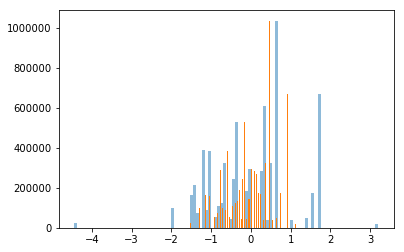

f_34


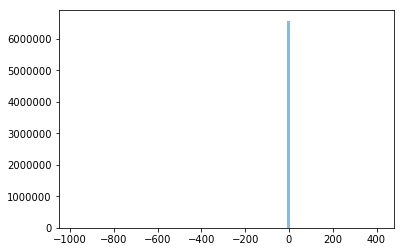

f_35


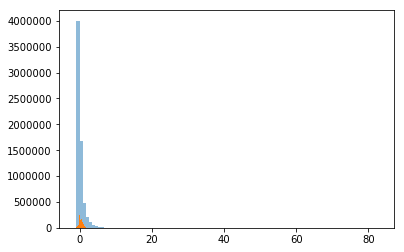

f_36


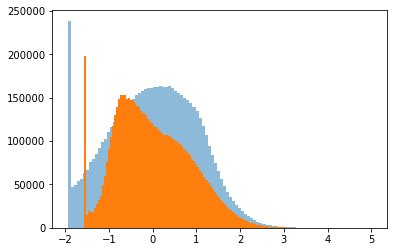

f_37


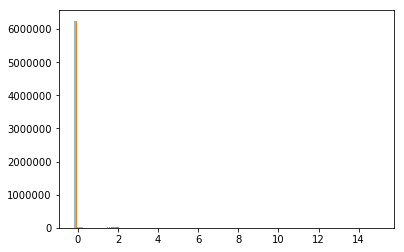

f_38


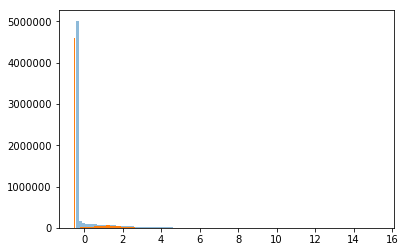

f_39


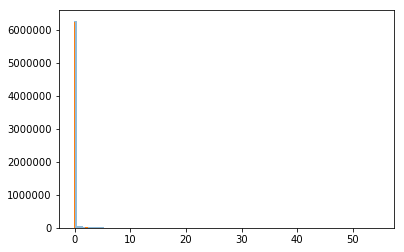

f_40


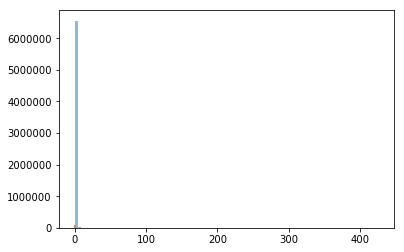

f_41


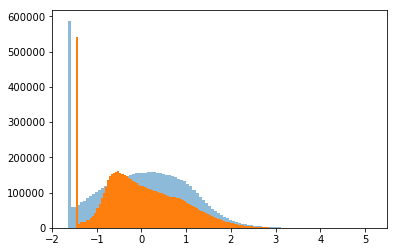

latest_target


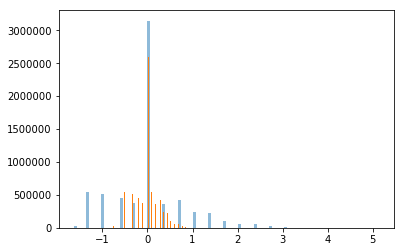

latest3_mean


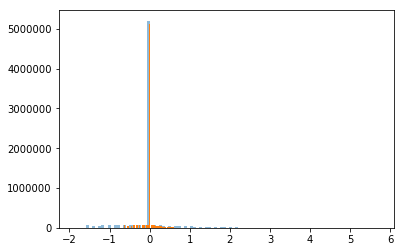

latest2_mean


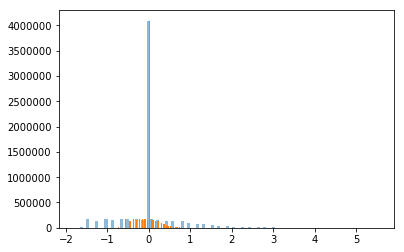

mkt_mean


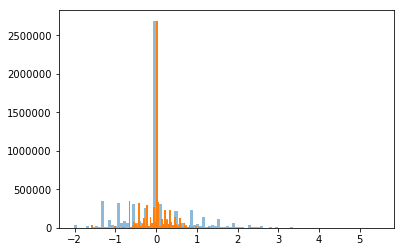

latest_target_nil


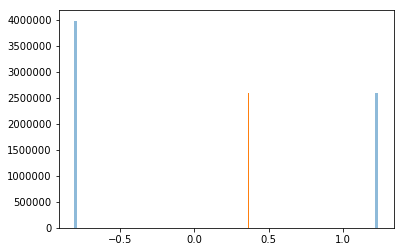

latest3_mean_nil


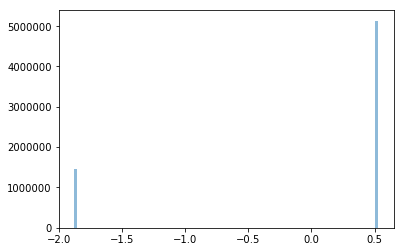

latest2_mean_nil


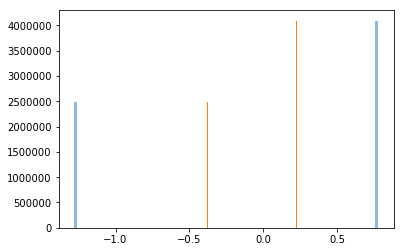

mkt_mean_nil


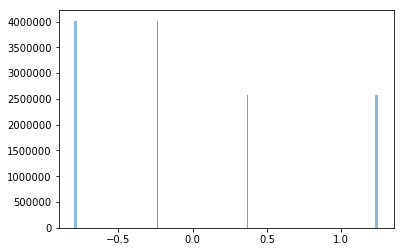

In [99]:
for i in range(df.shape[1]):
    print df.columns[i]
    plt.hist(df.iloc[:,i],bins=100,alpha=0.5)
    plt.hist(newdf.iloc[:,i],bins=100)
    plt.show()

In [100]:
extras=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2.parq").to_pandas()[['target','fold']]

In [104]:
newdf['target']=extras['target']
newdf['fold']=extras['fold']

In [106]:
newdf.head()

rg_market    rg_f_0    rg_f_1    rg_f_2    rg_f_3    rg_f_4    rg_f_5  \
id                                                                          
0    0.035812 -0.348419  0.378236  0.058975 -0.524848 -1.824387 -0.256815   
1    1.214460 -0.468288  0.378236  0.058975 -1.768761 -1.824387 -0.422656   
2    0.035812  0.494904  0.378236  0.474373 -0.465817 -0.601286 -0.669869   
3    0.813589 -0.468288 -0.098144  0.058975  0.226707 -1.824387  0.898580   
4   -0.552426 -0.230236  0.378236 -0.714344  0.456660  1.295362  0.498469   

      rg_f_6    rg_f_7    rg_f_8  ...   rg_latest_target  rg_latest3_mean  \
id                                ...                                       
0  -0.097357  1.158592  0.862580  ...           0.007937         0.005797   
1   1.143111  0.386018  0.685852  ...           0.007937         0.005797   
2  -0.097357  0.406729 -0.426685  ...          -0.507388        -0.343168   
3  -0.097357  0.479370  0.485734  ...           0.007937         0.005797   
4  -0.097357  0.814817 -0.066451  ...          -0.206565         0.110730   

    rg_latest2_mean  rg_mkt_mean  rg_latest_target_nil  rg_latest3_mean_nil  \
id                                                                            
0          0.009837     0.038103              0.368070             0.133769   
1          0.009837     0.038103              0.368070             0.133769   
2         -0.578637    -0.310620             -0.240422            -0.474723   
3          0.009837     0.038103              0.368070             0.133769   
4          0.060976     0.292656             -0.240422            -0.474723   

    rg_latest2_mean_nil  rg_mkt_mean_nil  target  fold  
id                                                      
0              0.230433         0.371281      -1     1  
1              0.230433         0.371281      -1     4  
2             -0.378059        -0.237211      -1     0  
3              0.230433         0.371281      -1     3  
4             -0.378059        -0.237211      -1     0  

[5 rows x 52 columns]

In [107]:
fastparquet.write("../../input/lr_train_num_combined_latest_target_v2_gr.parq",newdf,compression="SNAPPY")